Dictionary Learning and Sparse Coding
=====================================

Sparse approximation problem formulations
-----------------------------------------

Sparsity-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{x} - D \underline{\gamma}\|_2^2 \quad\text{s.t.}\quad
  \|\underline{\gamma}\|_0 \leq K$
  
Error-constrained: $\underline{\hat{\gamma}} = \underset{\underline{\gamma}}{arg\,min}\|\underline{\gamma}\|_0 \quad\text{s.t.}\quad \|\underline{x} - D \underline{\gamma}\|_2^2 \leq \epsilon$

Dictionary learning
-------------------


In [20]:
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np

# Load signal used to build the dictionary
from scipy.io import wavfile

# import os
# os.chdir("/path/to/wav")
# fs, data = wavfile.read("03 Shot In The Back Of The Head.wav")
fs, data = wavfile.read("BohemianRhapsody_Mono16_16khz.wav")

print(data.dtype)

# http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
# the sound pressure values are mapped to integer values that can range 
# from -2^15 to (2^15)-1. We can convert our sound array to floating point
# values ranging from -1 to 1 as follows:
data = data / 2.0**15
data.shape

int16


(5664183,)

In [21]:
data.shape
fs
# data[0:fs * 20].shape[0] / 256

16000

In [35]:
# train an initial dictionary on 10 seconds of signal
training_data = data[0:fs * 10]
training_data

array([ 0.        ,  0.        ,  0.        , ...,  0.05084229,
        0.05154419,  0.03509521])

In [36]:
training_data = training_data.reshape(int(training_data.shape[0] / 256),256)

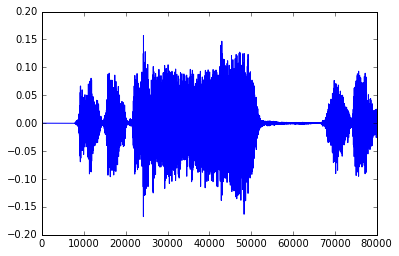

In [34]:
%matplotlib inline

plt.plot(data[0:fs*5])

# play 20 seconds of signal
from IPython.display import Audio
Audio(rate=fs, data=data[0:fs * 30])

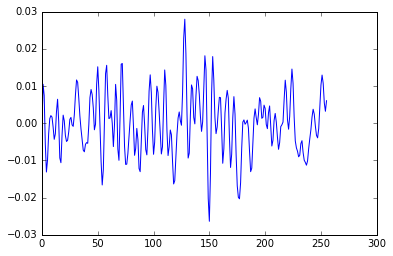

In [7]:
# Example of a speech frame
plt.plot(training_data[10])
Audio(data = training_data[10], rate=fs)

In [37]:
# Build the initial dictionary
from sklearn.decomposition import MiniBatchDictionaryLearning
from time import time
t0 = time()

# by default, fit with LARS and transform with OMP
dico = MiniBatchDictionaryLearning(n_components = 1024, alpha = 1, n_iter = 200)
D = dico.fit(training_data).components_
t1 = time() - t0
print('Trained in %d seconds' % t1)

Trained in 209 seconds


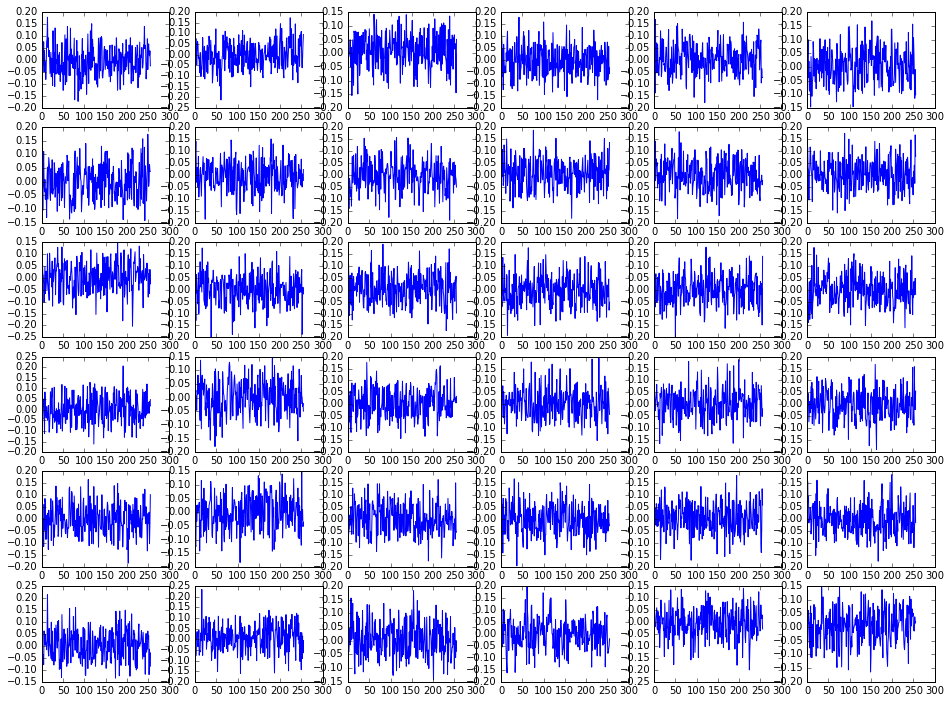

In [26]:
import itertools
# Example of an entry from the dictionary
fig, axes = plt.subplots(6,6)
fig.set_size_inches(16,12)
for i, j in itertools.product(range(1,7), range(6)):
    axes[i-1][j].plot(D[6*(i-1)+j])

Online learning with update
[example from scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_dict_face_patches.html)

Reconstructing speech segments using sparse coding with the learned dictionary
------------------------------------------------------------------------------

Now that we have a dictionary which (supposedly) is good for representing speech signals, let's use Orthogonal Matching Pursuit (OMP) to reconstruct a speech segment based on a linear combination of dictionary entries.

In [40]:
# Get sample speech segment to reconstruct
test_data = data[fs * 11:fs*31].reshape(int(fs * 20 / 256), 256)
test_data.shape
# Reconstruct it frame-by-frame using a linear combination of 100 atoms per frame (sparsity-constrained OMP)
result = np.ndarray((test_data.shape[0],512))

from sklearn.decomposition import SparseCoder

coder = SparseCoder(dictionary = D, transform_n_nonzero_coefs = 50, 
                    transform_alpha = None, transform_algorithm = "omp")

t0 = time()
result = coder.transform(test_data)
t1 = time() - t0
print('Coded signal using OMP and learned dictionary in %d seconds.' % t1)

Coded signal using OMP and learned dictionary in 38 seconds.


In [41]:
orig = data[fs * 11:fs * 31]
out = np.zeros(orig.shape)

for n in range(result.shape[0]):
    out[n * 256:(n + 1) * 256] = np.sum(D.T * result[n],axis = 1)

In [42]:
Audio(data = out, rate = fs)

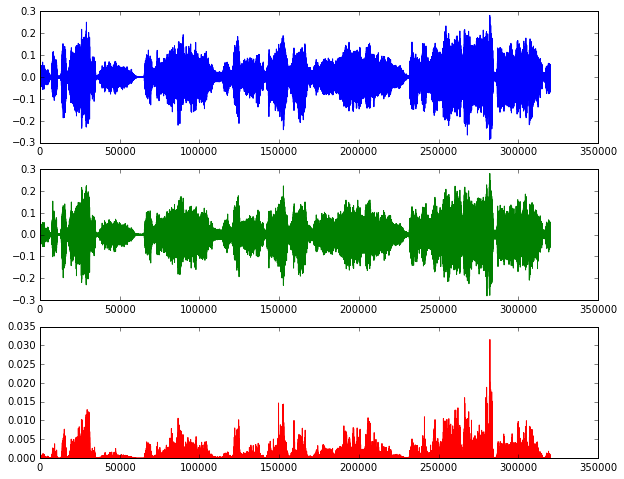

In [43]:
fig, axes = plt.subplots(3)
fig.set_size_inches(10,8)

axes[0].plot(orig)
axes[1].plot(out, 'g')
axes[2].plot((out-orig)**2, 'r')

In [83]:
wavfile.write('reconst.wav', 16000, np.asarray(out, dtype = np.float32))
wavfile.write('orig.wav', 16000, np.asarray(orig, dtype = np.float32))